In [2]:
#import the libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.utils.validation import  check_is_fitted


Automate data acquization and preparation using Wrangle function: 
Takes file path as argument and return DF
Return only property in Capital Federal that are appartments consting <400000
Rm outliers in "surface_covered_in_m2" all observation outside 10th and 90th percentile. Observations should fall between the 0.1 and 0.9 quantiles



In [3]:
def wrangle(path):
    df = pd.read_csv(path)
    subsetcity = df['place_with_parent_names'].str.contains("Capital Federal") 
    subsetype = df["property_type"] == 'apartment'
    subsetprc = df["price_aprox_usd"] < 400000 
    df = df[subsetcity & subsetype & subsetprc]
    #drop the first column
    df = df.drop(columns = ['Unnamed: 0'])
    area = df["surface_covered_in_m2"]
    low,high = area.quantile([0.1, 0.9])
    subsetarea = area.between(low,high)
    df = df[subsetarea]
    return (df)

In [4]:
df = wrangle(r"C:\Users\Administrator\Desktop\Data Expert\Data Analytics\Projects\World Quant\Housing in Buenos Aires\data\buenos-aires-real-estate-1.csv")
print(df.shape)
df.head()

(1343, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,sell,apartment,|Argentina|Capital Federal|Constitución|,"-34.6252219,-58.3823825",57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...
41,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...


Text(0.5, 1.0, 'Distribution of Apartment Size in Capital Federal')

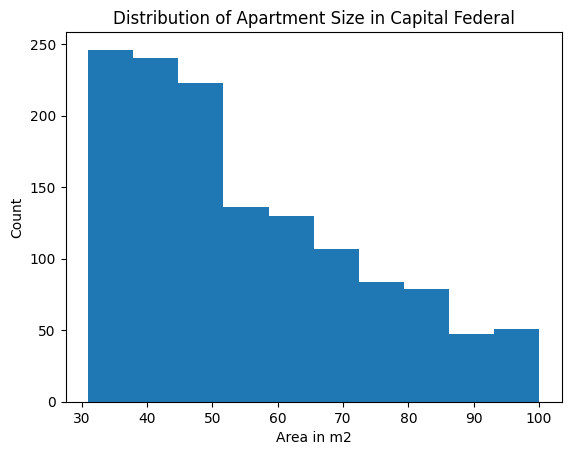

In [5]:
#histogram on area 
plt.hist(df["surface_covered_in_m2"], bins=10)
plt.xlabel("Area in m2")
plt.ylabel("Count")
plt.title("Distribution of Apartment Size in Capital Federal")

In [6]:
#Summary statistics on area before removing outliers Min = 0 and Max = 62034 Mean = 98
df["surface_covered_in_m2"].describe()
#df.info()

count    1343.000000
mean       55.076694
std        18.160427
min        31.000000
25%        40.000000
50%        50.000000
75%        68.500000
max       100.000000
Name: surface_covered_in_m2, dtype: float64

Text(0.5, 1.0, 'Price vs Area of Apartment in Capital Federal')

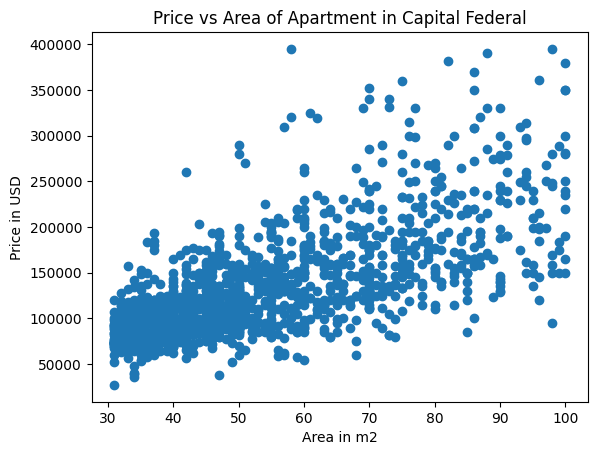

In [ ]:
#explore the relationship between size and price
plt.scatter(df["surface_covered_in_m2"], df["price_aprox_usd"])
plt.xlabel("Area in m2")
plt.ylabel("Price in USD")
plt.title("Price vs Area of Apartment in Capital Federal")

In [17]:
#Split the target(y_train) and feature(X_train) and create a feature matrix
features = ["surface_covered_in_m2"]
X_train= df[features]
X_train.shape


(1343, 1)

In [9]:
#Create the target vector
target = "price_aprox_usd"
y_train = df["price_aprox_usd"]
y_train.shape

(1343,)

In [10]:
#Build a naive / baseline model that always predicts the mean of y_train
y_mean = y_train.mean()
y_mean

np.float64(135527.83871928515)

In [18]:
y_predbase = [y_mean] * len(y_train)
y_predbase[:3]
#len(y_mean) == len(y_predbase)

[np.float64(135527.83871928515),
 np.float64(135527.83871928515),
 np.float64(135527.83871928515)]

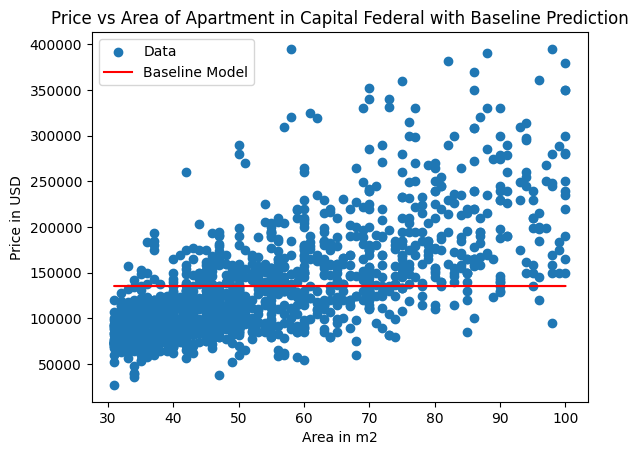

In [12]:
#show the relationship between size and price with the baseline prediction
plt.scatter(X_train, y_train, label='Data')
#plt.axhline(y=y_mean, color='r', linestyle='--', label='Baseline Model (Mean Price)')
plt.plot(X_train, y_predbase, color = 'r', label = "Baseline Model" )
plt.xlabel("Area in m2")
plt.ylabel("Price in USD")  
plt.title("Price vs Area of Apartment in Capital Federal with Baseline Prediction")
plt.legend()
#Calculate the RMSE for the baseline model
#rmse_base = mean_squared_error(y_train, y_predbase, squared=False)

Performance Metrics: An error is difference btwn measurement and reality. In stats this is accounted for using MAE. Absolute error is error in a single measure while Mean Absolute Error is avg of erro accross several measures. 
In our case: on average, our model's predictions are off by $45199.46 thus MAE below this is better 

In [19]:
#calculate the MAE for the baseline model
mae_base = mean_absolute_error(y_predbase, y_train)
print("Prediction",round(y_mean,2))
print("MAE",round(mae_base, 2)) 


Prediction 135527.84
MAE 45199.46


In [20]:
#iterative process: model building, training and evaluation
model = LinearRegression()
model.fit(X_train, y_train)
#check_is_fitted(model)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [21]:
#predict the prices
y_trainpred = model.predict(X_train)
print("Predicted Prices",y_trainpred[:10])
print("Training Price Data:",y_train.head(10))


Predicted Prices [169151.87330223 106064.44707446 133101.91545779 106064.44707446
 124089.42599668 178164.36276334  83533.22342168 124089.42599668
 128595.67072723 171404.99566751]
Training Price Data: 4     129000.0
9      87000.0
29    118000.0
40     57000.0
41     90000.0
48    138000.0
58    114000.0
62     82000.0
70    166000.0
72    136500.0
Name: price_aprox_usd, dtype: float64


In [22]:
#MAE for the linear regression model
mae_train = mean_absolute_error(y_trainpred, y_train)
mae_train

31248.2561380616

Using the trained data we evaluate our model, predict price of unkown set of data and test model accuracy

In [30]:
#Model Evaluation
testdf = pd.read_csv(r"C:\Users\Administrator\Desktop\Data Expert\Data Analytics\Projects\World Quant\Housing in Buenos Aires\data\buenos-aires-test-features.csv", index_col = False)
if 'Unnamed: 0' in testdf.columns:
    testdf = testdf.drop('Unnamed: 0', axis=1)

testdf.head(4)

,surface_covered_in_m2,lat,lon,neighborhood
0,47,-34.615310,-58.361983,Puerto Madero
1,55,-34.547298,-58.462705,Nuñez
2,34,-34.617762,-58.383662,Monserrat
3,34,-34.639925,-58.438406,Parque Chacabuco


In [34]:
#check for missing values
testdf.isnull().sum()
#drop rows with missing values
#testdf = testdf.dropna()

surface_covered_in_m2    0
lat                      0
lon                      0
neighborhood             0
dtype: int64

In [36]:
#evaluate the model on test data
X_test = testdf[features]
y_predttest = model.predict(X_test)
y_predttest[:10]


array([117330.05890084, 135355.03782307,  88039.46815224,  88039.46815224,
       106064.44707446, 169151.87330223, 119583.18126612, 169151.87330223,
       151126.89438001, 117330.05890084])

Linear Regression: prediction of some value by relation ship with another
y = mx+ b where y = intercept b = beta coefficient showing what/ level of change to expect to see in X for every unit inc of yy

In [ ]:

#get intercept and coefficient
intercept = model.intercept_
coefficient = model.coef_
print("Intercept",intercept)
print("Coefficient",coefficient)
#y = mx + b
print(f"apartment_price = intercept + coefficient * surface_covered_in_m2")

Intercept 11433.307732797926
Coefficient [2253.12236528]
apartment_price = intercept + coefficient * surface_covered_in_m2


Text(0.5, 0, 'Area in m2')

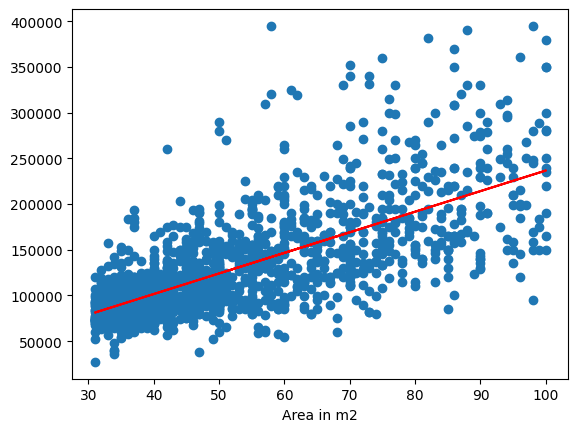

In [43]:
#show relationship btwn Xtrain and model prediction 
plt.scatter(X_train, y_train, label='Data')
plt.plot(X_train, y_trainpred, color = 'r', label = "Linear Regression Model" )
plt.xlabel("Area in m2") 